# Імпорт бібілотек

In [1]:

# !pip install pandas
# !pip install numpy
# !pip install tensorflow
# !pip install setuptools
# !pip install keras
# !pip install keras-tuner
# !pip install seaborn
# !pip install matplotlib
# !pip install scikit-learn
# !pip install scipy
# !pip install statsmodels
# !pip install pvlib
# !pip install xgboost
# !pip install ipython

In [2]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dense, Dropout, 
                                     LSTM, GRU, Bidirectional, RepeatVector, TimeDistributed, 
                                     Add, Multiply, Activation, Reshape, BatchNormalization)

from tensorflow.keras.layers import MultiHeadAttention, Permute
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_log_error, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

from statsmodels.graphics.tsaplots import plot_acf

from IPython.display import display

import pvlib



### Завантаження даних

In [3]:
data_name_predict = 'Glyniany-1_OpenMeteo_Data'
data_name_actual = 'Glyniany-1_Nordik_Data'
power_max = 7153 # максимальна потужність станції
latitude = 49.308290
longitude = 23.430082

# data_name_predict = 'Glyniany-1_OpenMeteo_Data'
# data_name_actual = 'Glyniany-1_Nordik_Data'
# power_max = 2976
# latitude = 49.826009
# longitude = 24.476087

# data_name_predict = 'Glyniany-2_OpenMeteo_Data'
# data_name_actual = 'Glyniany-2_Nordik_Data'
# power_max = 15442
# latitude = 49.826411
# longitude = 24.488083

# data_name_predict = 'Yavoriv_OpenMeteo_Data'
# data_name_actual = 'Yavoriv_Nordik_Data'
# power_max = 59234
# latitude = 49.935239
# longitude = 23.505527


In [4]:
# Завантаження даних з прогнозними меткопараметрами
df_predict = pd.read_csv(f'../Data/{data_name_predict}.csv', sep=',', comment='#', low_memory=False)

# Виключення колонок 'power' та 'limitation', якщо вони є
df_predict = df_predict[[col for col in df_predict.columns if col not in ['power', 'limitation']]]
# Перейменування колонок
df_predict = df_predict.rename(columns={col: f"{col}_predict" for col in df_predict.columns if col != 'datetime'})


# Завантаження даних з фактичними даними аотужності
df_actual = pd.read_csv(f'../Data/{data_name_actual}.csv', sep=',', comment='#', low_memory=False)
df_actual = df_actual.rename(columns={col: f"{col}_actual" for col in df_actual.columns if col != 'datetime'})

_data = pd.DataFrame()
_data = pd.merge(df_actual, df_predict, on='datetime', how='outer', suffixes=('_actual', '_predict'))

### Обробка даних

In [5]:
# Перетворення колонки 'datetime' в тип datetime
_data['datetime'] = pd.to_datetime(_data['datetime'], format='mixed', errors='coerce')

In [6]:
# обмеження значень по максимальній потужності станції 
_data['power_acual'] = _data['power_actual'].clip(lower=0, upper=power_max)

# Видалення невалідних значень потужності
_data = _data.dropna(subset=['power_actual'])

In [7]:
# Видалення невалідних записів при обмеження генерації
_data["limitation_actual"] = _data["limitation_actual"].fillna(0)
_data = _data[_data['limitation_actual'] == 0]
_data.drop(columns=['limitation_actual'], inplace=True)

### Розрахунок метрик

In [8]:
# Розрахунок метрик
def evaluate_data(_forecast, _actual, _power_max=0, _print_metrics=False):

        if _power_max == 0:
            _power_max = np.max(_actual)

        tae = np.sum(np.abs(_forecast - _actual))

        mae = mean_absolute_error(_actual, _forecast)
        mae_max = (mae / _power_max) * 100

        ape_koef = 0.1
        mask = _actual > ape_koef * _power_max
        if np.any(mask):
            ape = np.mean(np.abs((_forecast[mask] - _actual[mask]) / _actual[mask])) * 100
        else:
            ape = np.nan

        mape = mean_absolute_percentage_error(_actual, _forecast) * 100
        mape_max = np.mean(np.abs((_forecast - _actual) / _power_max)) * 100  

        def symmetric_mean_absolute_percentage_error(actual, forecast):
            numerator = np.abs(actual - forecast)
            denominator = (np.abs(actual) + np.abs(forecast)) / 2
            smape = np.mean(numerator / denominator) * 100
            return smape
        smape = symmetric_mean_absolute_percentage_error(_actual, _forecast)

        mse = mean_squared_error(_actual, _forecast)

        rmse = np.sqrt(mse)
        rmse_max = np.sqrt(mse) / _power_max * 100

        r2 = r2_score(_actual, _forecast)
        ev = explained_variance_score(_actual, _forecast)

        bias = np.mean(_forecast - _actual) / _power_max * 100

        msle = mean_squared_log_error(_actual - np.min(_actual) + 1,
                                      _forecast - np.min(_forecast) + 1)
        try:
            pcc, _ = pearsonr(_actual - np.min(_actual) + 1,
                              _forecast - np.min(_forecast) + 1)
        except ValueError: pcc = np.nan

        metrics = {
            "TAE": tae,
            "MAE": mae,
            "MAE(max)": mae_max,
            "APE": ape,
            "MAPE": mape,
            "MAPE(max)": mape_max,
            "sMAPE": smape,
            "MSE": mse,
            "RMSE": rmse,
            "RMSE(max)": rmse_max,
            "R2": r2,
            "MSLE": msle,
            "EV": ev,
            "PCC": pcc,
            "Bias": bias,            
        }

        if _print_metrics:
            for key, value in metrics.items():
                print(f"{key}: {value:.3f}")

        return metrics

Метрики прогнозу

- `Generation` - агальний обсяг реальної генерації енергії.
- `Prediction` - загальний обсяг прогнозованої генерації енергії.
- `TAE` - загальна похибка між реальними та прогнозованими значеннями.
- `MAE` - середня абсолютна помилка. Середнє абсолютне відхилення прогнозу від реальних даних. `MAE = mean(|generation - prediction|)`
- `MAE(max)` - середня абсолютна помилка відносно максимальної генерації. `MAE (max) = (MAE / max(generation)) * 100`
- `APE` - відносна похибка, що показує відхилення прогнозу від реальної генерації у відсотках. `APE = (TAE / Generation) * 100`
- `MAPE` - середня абсолютна похибка у відсотках. `MAPE = mean(|(generation - prediction) / generation|) * 100`
- `MAPE(max)` - середня абсолютна похибка у відсотках. `MAPE = mean(|(generation - prediction) / power_max|) * 100`
- `sMAPE` - 
- `MSE` - середньоквадратична похибка. `MSE = mean((generation - prediction)^2)`. Чутлива до великих відхилень похибка.
- `RMSE` - корінь середньоквадратичної похибки. `RMSE = sqrt(MSE)`. Пояснює середнє відхилення прогнозу від реальних даних.
- `RMSE(max)` - корінь середньоквадратичної похибки відносно максимальної генерації. `RMSE (max) = (RMSE / power_max) * 100`
- `R2` - Коефіцієнт детермінації. `R2 = 1 - (sum((generation - prediction)^2) / sum((generation - mean(generation))^2))`. Якість відповідності прогнозу фактичним даним. Враховує лінійну залежність.
- `MSLE` - середньоквадратична логарифмічна похибка. `MSLE = mean((log(generation + 1) - log(prediction + 1))^2)`. Відносна похибка з урахуванням 
- `EV` - пояснена дисперсія. `EV = 1 - (variance(generation - prediction) / variance(generation))`. Показує наскільки добре модель пояснює варіації фактичними даних.
логарифмічної шкали.
- `PCC` - коефіцієнт кореляції Пірсона. `PCC = cov(generation, prediction) / (std(generation) * std(prediction))`. Лінійна залежність між прогнозом і фактичними даними.
- `Bias` - нормалізоване зміщення прогнозу. Пояснює систематичне відхилення між прогнозом і реальністю. `Bias = mean((generation - prediction) / generation) * 100`


### Відображення даних

In [9]:
# Відображення функції втрат
def plot_loss(history, title = f'Training and Validation Loss'):
    plt.figure(figsize=(5, 3))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
# Відображення матриці кореляції
def plot_correlation_matrix(df):
    plt.figure(figsize=(15, 10))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
    plt.title('Матриця кореляції', fontsize=16)
    plt.tight_layout()  
    plt.show()

In [11]:
# Відображення часових рядів
def plot_series(_data, _columns, _title="Фактична і Прогнозована потужність", _metrics=None, _split_days=0):

    # Дата-час може бути в індексі або в колонці "datetime"
    if "datetime" in _data.columns:
        datetime_col = _data["datetime"]
    else:
        datetime_col = _data.index

    start_index = 0
    end_index = len(_data)
    data_plot = _data.iloc[start_index:end_index].copy()
    datetime_col_plot = datetime_col[start_index:end_index]

    # Візуалізація графіків
    plt.figure(figsize=(15, 5))
    for col in _columns:
        plt.plot(datetime_col_plot, data_plot[col["column"]], label=col["label"])
    plt.title(f"{_title}")
    
    # Візуалізація метрик
    metrics_text = ""
    if _metrics is not None:
        metrics_text = "\n".join([
            f'APE = {_metrics["APE"]:.2f}%',
            f'MAPE(max) = {_metrics["MAPE(max)"]:.1f}%',            
            f'RMSE(max) = {_metrics["RMSE(max)"]:.1f}%',
            f'R2 = {_metrics["R2"]:.3f}',
            f'MSLE = {_metrics["MSLE"]:.3f}',
            f'Bias = {_metrics["Bias"]:.1f}',
            # f'sMAPE = {_metrics["MAPE"]:.1e}',
            f'EV = {_metrics["EV"]:.3f}',
            f'PCC = {_metrics["PCC"]:.3f}'
        ])
        
    plt.legend(loc='upper left', title=metrics_text)
    
    plt.grid(True)
    plt.show()

    # Візуалізація графіків по частинах
    if _split_days > 0:
        data_len = len(_data)
        days_in_step = _split_days * 24 * 4
        for i in range(0, data_len, days_in_step):
            data_chunk = _data.iloc[i:i + days_in_step]
            datetime_chunk = datetime_col.iloc[i:i + days_in_step]

            plt.figure(figsize=(15, 5))
            for col in _columns:
                plt.plot(datetime_chunk, data_chunk[col["column"]], label=col["label"])
            plt.title(f"{_title} - Інтервал {i // days_in_step + 1}")
            plt.legend(loc='upper left')
            plt.grid(True)
            plt.show()

In [12]:
# Графік відносних залишків
def plot_residuals(_y_train_actual=None, _y_train_forecast=None, _y_test_actual=None, _y_test_forecast=None, _power_max=0, _title="Графік відносних залишків"):

    plt.figure(figsize=(10, 5))

    # Автоматичне визначення power_max, якщо він не заданий
    if _power_max == 0:
        max_train = max(_y_train_actual) if _y_train_actual is not None else 0
        max_test = max(_y_test_actual) if _y_test_actual is not None else 0
        _power_max = max(max_train, max_test)
        _power_max = max(_power_max, 1)
        
    # Перевірка та побудова графіка для навчальних даних
    if _y_train_actual is not None and _y_train_forecast is not None:
        train_residuals = (_y_train_actual - _y_train_forecast) / _power_max
        plt.scatter(_y_train_forecast, train_residuals, alpha=0.5, color='#87CEEB', marker='o', label='Навчальні дані')

    # Перевірка та побудова графіка для тестових даних
    if _y_test_actual is not None and _y_test_forecast is not None:
        test_residuals = (_y_test_actual - _y_test_forecast) / _power_max
        plt.scatter(_y_test_forecast, test_residuals, alpha=0.5, color='#FFD700', marker='s', label='Тестові дані')

    # Лінія нульових залишків
    plt.axhline(0, color='black', linewidth=2, linestyle='--', label='Лінія 0 залишків')

    plt.xlabel('Прогнози, кВт')
    plt.ylabel('Відносні залишки')
    plt.title(_title)
    plt.legend(loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

### Створення ознак

In [13]:
# Конвертувати datetime у об'єкт datetime бібліотеки pandas
_data["datetime"] = pd.to_datetime(_data["datetime"], utc=True)

# Виділити день і годину для трансформацій синуса та косинуса
_data["hour"] = _data["datetime"].dt.hour
_data["day"] = _data["datetime"].dt.dayofyear
_data["hour_sin"] = np.sin(2 * np.pi * _data["hour"] / 24)
_data["hour_cos"] = np.cos(2 * np.pi * _data["hour"] / 24)
_data["day_sin"] = np.sin(2 * np.pi * _data["day"] / 365.25)
_data["day_cos"] = np.cos(2 * np.pi * _data["day"] / 365.25)

In [14]:
# Розрахунок висоти сонця [apparent_elevation_predict]
def calculate_apparent_elevation(row):
    solar_position = pvlib.solarposition.get_solarposition(
        time=row['datetime'],
        latitude=latitude,
        longitude=longitude,
    )
    return max(solar_position['apparent_elevation'].iloc[0],0)

_data['apparent_elevation_predict'] = _data.apply(calculate_apparent_elevation, axis=1)
_data['is_night_predict'] = _data['apparent_elevation_predict'] <= 0

### Підготовка даних для навчання

In [15]:
features_train = [
       'power_actual',
       
       # 'gti_actual',
       # 'ghi_actual',

       # 'temperature_air_actual',
       # 'temperature_pv_actual',

       'gti_predict',
       'ghi_predict',
       'dni_predict',

       'temperature_air_predict',
       'temperature_soil_predict',

       'cloud_cover_high_predict',
       'cloud_cover_low_predict',
       'cloud_cover_mid_predict',
       
       'dew_point_predict',
       'humidity_predict',
       'pressure_air_predict',
       'sunshine_predict',
       'visibility_predict',
       'wind_speed_predict',
       'wind_direction_predict',
       'weather_code_predict',

       'hour_sin',
       'hour_cos',
       'day_sin',
       'day_cos',
       'apparent_elevation_predict',
       'is_night_predict',
       ]

In [16]:
df_train = _data[features_train].copy()

In [17]:
df_train.dropna(inplace=True)

In [18]:
# Вибрані ознаки
feature_columns = [col for col in df_train.columns if col != "power_actual"]

# feature_columns = ['gti', 'temperature_air', 'humidity', 'apparent_elevation', 'is_night', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']
# feature_columns = [col for col in feature_columns if col in df_train.columns]

# Цільова змінна
target_column = 'power_actual'

# Вибірка даних для моделі
# Перша колонка - цільова змінна power, інші - ознаки
df_train = df_train[[target_column] + feature_columns]

In [19]:
# Розділення даних на навчальну та тестову вибірки
split_ratio = 0.8

split_index = int(len(df_train) * split_ratio)
data_train = df_train.iloc[:split_index]
data_test = df_train.iloc[split_index:]

In [20]:
# Масштабування даних для навчання моделей
sequence_length = 12
forecast_steps = 96

scaler = MinMaxScaler()
data_train_scaled = scaler.fit_transform(data_train)
data_test_scaled = scaler.transform(data_test)

def prepare_sequences(scaled_data, original_data, sequence_length, forecast_steps):
    X, y, datetimes = [], [], []
    for i in range(sequence_length, len(scaled_data) - forecast_steps + 1):
        y.append(scaled_data[i:i+forecast_steps, 0])    # цільова змінна 'power_actual'
        X.append(scaled_data[i-sequence_length:i, 1:])  # ознаки
        datetimes.append(original_data.index[i+forecast_steps-1])
    return np.array(X), np.array(y), datetimes


X_train, y_train, datetimes_train = prepare_sequences(data_train_scaled, data_train, sequence_length, forecast_steps)
print(f"Length of X_train: {len(X_train)}")
print(f"Length of y_train: {len(y_train)}")
print(f"Length of datetimes_train: {len(datetimes_train)}")

X_test, y_test, datetimes_test = prepare_sequences(data_test_scaled, data_test, sequence_length, forecast_steps)
print(f"Length of X_test: {len(X_test)}")
print(f"Length of y_test: {len(y_test)}")
print(f"Length of datetimes_test: {len(datetimes_test)}")

print(f"X_train size: {len(X_train)}")
print(f"X_test size: {len(X_test)}")
print(f"Features ({len(feature_columns)}): {feature_columns}")

Length of X_train: 13514
Length of y_train: 13514
Length of datetimes_train: 13514
Length of X_test: 3299
Length of y_test: 3299
Length of datetimes_test: 3299
X_train size: 13514
X_test size: 3299
Features (22): ['gti_predict', 'ghi_predict', 'dni_predict', 'temperature_air_predict', 'temperature_soil_predict', 'cloud_cover_high_predict', 'cloud_cover_low_predict', 'cloud_cover_mid_predict', 'dew_point_predict', 'humidity_predict', 'pressure_air_predict', 'sunshine_predict', 'visibility_predict', 'wind_speed_predict', 'wind_direction_predict', 'weather_code_predict', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'apparent_elevation_predict', 'is_night_predict']


### Створення моделей

In [21]:
model_data_list = []

#### LSTM

In [22]:
lstm_extended = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(
        units=128,
        activation='relu',
        return_sequences=True,
    ),
    Dropout(0.1),
    BatchNormalization(),
    LSTM(
        units=256,
        activation='relu',
        return_sequences=True,
    ),
    Dropout(0.1),
    BatchNormalization(),
    LSTM(
        units=128,
        activation='relu',
        return_sequences=True,
    ),
    LSTM(50, return_sequences=False),
    Dense(forecast_steps, activation='linear')
])
lstm_extended.compile(optimizer='nadam', loss='mse')

model_data_list.append({
    'name': "lstm_extended",
    'model': lstm_extended,
    'params': None,
    'data': None,
    'history': None,
    'metrics': None
})

#### CNN + LSTM 

In [23]:
cnn_lstm_simple = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    
    # CNN блок
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2, padding='same'),
    
    # LSTM блок
    LSTM(50, return_sequences=False),
    
    # Вихідний шар
    Dense(forecast_steps)
])

# Компіляція моделі
cnn_lstm_simple.compile(optimizer='adam', loss='mse')

model_data_list.append({
    'name': "cnn_lstm_simple",
    'model': cnn_lstm_simple,
    'params': None,
    'data': None,
    'history': None,
    'metrics': None
})

In [24]:
cnn_lstm_moderate = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    
    # CNN блок
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    Dropout(0.2),
    
    # LSTM блок
    LSTM(64, return_sequences=True),
    Dropout(0.1),
    LSTM(64, return_sequences=False),
    
    # Fully Connected Layers
    Dense(50, activation='relu'),
    Dense(forecast_steps)
])

# Компіляція моделі
cnn_lstm_moderate.compile(optimizer='adam', loss='mse')

model_data_list.append({
    'name': "cnn_lstm_moderate",
    'model': cnn_lstm_moderate,
    'params': None,
    'data': None,
    'history': None,
    'metrics': None
})

In [25]:
cnn_lstm_extended = Sequential([

    Input(shape=(X_train.shape[1], X_train.shape[2])),
    
    # CNN блок
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),  # Додано padding='same'
    Dropout(0.2),
    
    # Другий CNN блок
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    Dropout(0.2),
    
    Reshape((-1, 64)),  # -1 визначає розмір автоматично, 64 — кількість фільтрів з CNN
    
    # LSTM блок
    LSTM(50, return_sequences=True),
    Dropout(0.1),
    LSTM(50, return_sequences=True),
    Dropout(0.1),
    LSTM(50, return_sequences=False),
    Dropout(0.1),
    
    # Fully Connected Layers
    Dense(25, activation='relu'),
    Dense(forecast_steps)
])

# Компіляція моделі
cnn_lstm_extended.compile(optimizer='nadam', loss='mse')

model_data_list.append({
    'name': "cnn_lstm_extended",
    'model': cnn_lstm_extended,
    'params': None,
    'data': None,
    'history': None,
    'metrics': None
})

In [26]:
cnn_lstm_deep = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    
    # CNN блок
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2, padding='same'),
    Dropout(0.2),
    
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2, padding='same'),
    Dropout(0.2),
    
    # LSTM блок
    LSTM(128, return_sequences=True),
    Dropout(0.1),
    LSTM(128, return_sequences=False),
    
    # Fully Connected Layers
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(forecast_steps)
])

# Компіляція моделі
cnn_lstm_deep.compile(optimizer='adam', loss='mse')

model_data_list.append({
    'name': "cnn_lstm_deep",
    'model': cnn_lstm_deep,
    'params': None,
    'data': None,
    'history': None,
    'metrics': None
})

In [27]:
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

# ResNet блок
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
residual = x  # Збереження для ResNet
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = Add()([x, residual])  # Додавання залишків
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.2)(x)

# LSTM блок
x = LSTM(50, return_sequences=True)(x)
x = Dropout(0.1)(x)
x = LSTM(50, return_sequences=False)(x)

# Fully Connected Layers
x = Dense(25, activation='relu')(x)
outputs = Dense(forecast_steps)(x)

# Модель
resnet_lstm = Model(inputs=inputs, outputs=outputs)

# Компіляція моделі
resnet_lstm.compile(optimizer='adam', loss='mse')

model_data_list.append({
    'name': "resnet_lstm",
    'model': resnet_lstm,
    'params': None,
    'data': None,
    'history': None,
    'metrics': None
})

In [28]:
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

# ResNet-стиль CNN блок
x = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(inputs)
residual = x  # Збереження для додавання
x = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = Add()([x, residual])  # Додавання залишків
x = MaxPooling1D(pool_size=2, padding='same')(x)
x = Dropout(0.2)(x)

# LSTM блок
x = LSTM(64, return_sequences=True)(x)
x = Dropout(0.1)(x)
x = LSTM(32, return_sequences=False)(x)

# Fully Connected Layers
x = Dense(25, activation='relu')(x)
outputs = Dense(forecast_steps)(x)

# Модель
model_resnet_cnn_lstm = Model(inputs=inputs, outputs=outputs)

# Компіляція моделі
model_resnet_cnn_lstm.compile(optimizer='adam', loss='mse')

model_data_list.append({
    'name': "resnet_cnn_lstm",
    'model': model_resnet_cnn_lstm,
    'params': None,
    'data': None,
    'history': None,
    'metrics': None
})

In [29]:
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN блок
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2, padding='same')(x)
x = Dropout(0.2)(x)

# LSTM блок
x = LSTM(50, return_sequences=True)(x)

# Шар уваги
attention = Dense(1, activation='tanh')(x)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(50)(attention)
attention = Permute([2, 1])(attention)

x = Multiply()([x, attention])
x = LSTM(50, return_sequences=False)(x)

# Fully Connected Layers
x = Dense(25, activation='relu')(x)
outputs = Dense(forecast_steps)(x)

# Модель
cnn_lstm_attention = Model(inputs=inputs, outputs=outputs)

# Компіляція моделі
cnn_lstm_attention.compile(optimizer='adam', loss='mse')

model_data_list.append({
    'name': "cnn_lstm_attention",
    'model': cnn_lstm_attention,
    'params': None,
    'data': None,
    'history': None,
    'metrics': None
})

In [30]:
cnn_lstm_deep_multi = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    
    # CNN блок
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2, padding='same'),
    Dropout(0.2),
    
    # LSTM блок
    LSTM(128, return_sequences=True),
    LSTM(64, return_sequences=True),
    Dropout(0.1),
    LSTM(32, return_sequences=False),
    
    # Fully Connected Layers
    Dense(50, activation='relu'),
    Dense(forecast_steps)
])

# Компіляція моделі
cnn_lstm_deep_multi.compile(optimizer='adam', loss='mse')

model_data_list.append({
    'name': "cnn_lstm_deep_multi",
    'model': cnn_lstm_deep_multi,
    'params': None,
    'data': None,
    'history': None,
    'metrics': None
})

In [31]:
cnn_lstm_encoder = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    
    # CNN енкодер
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2, padding='same'),
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2, padding='same'),
    Dropout(0.2),
    
    # LSTM декодер
    LSTM(64, return_sequences=True),
    LSTM(64, return_sequences=False),
    
    # Fully Connected Layers
    Dense(25, activation='relu'),
    Dense(forecast_steps)
])

# Компіляція моделі
cnn_lstm_encoder.compile(optimizer='adam', loss='mse')

model_data_list.append({
    'name': "cnn_lstm_encoder",
    'model': cnn_lstm_encoder,
    'params': None,
    'data': None,
    'history': None,
    'metrics': None
})

In [32]:
cnn_globalpool_lstm = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    
    # CNN блок із глобальним пулінгом
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    GlobalMaxPooling1D(),
    Dropout(0.2),
    
    # LSTM блок
    RepeatVector(X_train.shape[1]),
    LSTM(64, return_sequences=True),
    LSTM(32, return_sequences=False),
    
    # Fully Connected Layers
    Dense(50, activation='relu'),
    Dense(forecast_steps)
])

# Компіляція моделі
cnn_globalpool_lstm.compile(optimizer='adam', loss='mse')

model_data_list.append({
    'name': "cnn_globalpool_lstm",
    'model': cnn_globalpool_lstm,
    'params': None,
    'data': None,
    'history': None,
    'metrics': None
})

In [33]:
cnn_bilstm_dense = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    
    # CNN блок
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2, padding='same'),
    Dropout(0.2),
    
    # BiLSTM блок
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.1),
    
    # Fully Connected Layers
    Dense(50, activation='relu'),
    Dense(forecast_steps)
])

# Компіляція моделі
cnn_bilstm_dense.compile(optimizer='adam', loss='mse')

model_data_list.append({
    'name': "cnn_bilstm_dense",
    'model': cnn_bilstm_dense,
    'params': None,
    'data': None,
    'history': None,
    'metrics': None
})


#### CNN + GRU

In [34]:
# model_cnn_gru = Sequential([
#     Input(shape=(X_train.shape[1], X_train.shape[2])),
    
#     # CNN блок
#     Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),  # Додано padding='same'
#     MaxPooling1D(pool_size=2, padding='same'),  # Щоб уникнути зменшення розміру до негативного
#     GRU(50, return_sequences=True),
#     Dropout(0.1),
#     GRU(50, return_sequences=False),
#     Dense(forecast_steps)
# ])

# # Компіляція моделі
# model_cnn_gru.compile(optimizer='nadam', loss='mse')

# models_list.append({
#     'name': "cnn_gru",
#     'model': model_cnn_gru,
#     'params': None,
#     'data': None,
#     'history': None,
#     'metrics': None
# })


#### CNN + Transformer

In [35]:
# # Побудова гібридної моделі CNN + Transformer

# # Вхідний шар
# inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

# # CNN частина
# x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
# x = MaxPooling1D(pool_size=2)(x)

# # Transformer частина
# # Для MultiHeadAttention потрібні query, key і value
# attn_output = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
# x = Flatten()(attn_output)

# # Повнозв'язний шар
# x = Dense(25, activation='relu')(x)
# outputs = Dense(1)(x)

# # Модель
# model_cnn_tranformers = Model(inputs=inputs, outputs=outputs)

# # Компіляція моделі
# model_cnn_tranformers.compile(optimizer='nadam', loss='mse')

# models_list.append({
#     'name': "cnn_tranformers",
#     'model': model_cnn_tranformers,
#     'params': None,
#     'data': None,
#     'history': None,
#     'metrics': None
# })

### Навчання моделей, прогнозування

In [36]:
model_data_list

[{'name': 'lstm_extended',
  'model': <Sequential name=sequential, built=True>,
  'params': None,
  'data': None,
  'history': None,
  'metrics': None},
 {'name': 'cnn_lstm_simple',
  'model': <Sequential name=sequential_1, built=True>,
  'params': None,
  'data': None,
  'history': None,
  'metrics': None},
 {'name': 'cnn_lstm_moderate',
  'model': <Sequential name=sequential_2, built=True>,
  'params': None,
  'data': None,
  'history': None,
  'metrics': None},
 {'name': 'cnn_lstm_extended',
  'model': <Sequential name=sequential_3, built=True>,
  'params': None,
  'data': None,
  'history': None,
  'metrics': None},
 {'name': 'cnn_lstm_deep',
  'model': <Sequential name=sequential_4, built=True>,
  'params': None,
  'data': None,
  'history': None,
  'metrics': None},
 {'name': 'resnet_lstm',
  'model': <Functional name=functional_5, built=True>,
  'params': None,
  'data': None,
  'history': None,
  'metrics': None},
 {'name': 'resnet_cnn_lstm',
  'model': <Functional name=functio

In [37]:
for model_data in model_data_list:

    model_name = model_data['name']
    print(f"==> {model_name}")
    
    model = model_data['model']

    # Тренування моделі
    model_data['history'] = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=32,
        batch_size=32,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
        verbose=1)
    
    # Отримання прогнозованих значень для тестових і навчальних даних
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # Відновлення масштабу для навчальних даних
    y_train_rescaled = scaler.inverse_transform(
        np.c_[y_train[:, 0], np.zeros((y_train.shape[0], scaler.n_features_in_ - 1))]
    )[:, 0]

    train_forecast_rescaled = scaler.inverse_transform(
        np.c_[y_train_pred[:, 0], np.zeros((y_train_pred.shape[0], scaler.n_features_in_ - 1))]
    )[:, 0]

    # Відновлення масштабу для тестових даних
    y_test_rescaled = scaler.inverse_transform(
        np.c_[y_test[:, 0], np.zeros((y_test.shape[0], scaler.n_features_in_ - 1))]
    )[:, 0]

    forecast_rescaled = scaler.inverse_transform(
        np.c_[y_test_pred[:, 0], np.zeros((y_test_pred.shape[0], scaler.n_features_in_ - 1))]
    )[:, 0]

    # Створення DataFrame з відновленими даними
    train_df = pd.DataFrame({
        "datetime": datetimes_train,
        "power_actual": y_train_rescaled,
        "power_predict": train_forecast_rescaled,
    })
    model_data['data_train'] = train_df.copy()

    test_df = pd.DataFrame({
        "datetime": datetimes_test,
        "power_actual": y_test_rescaled,
        "power_predict": forecast_rescaled
    })
    model_data['data'] = test_df.copy()

    # Розрахунок метрик
    model_data['metrics'] = evaluate_data(model_data['data']['power_actual'], model_data['data']['power_predict'], _power_max=power_max, _print_metrics=False)


==> lstm_extended
Epoch 1/32
423/423 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.0469 - val_loss: 0.0244
Epoch 2/32
423/423 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0208 - val_loss: 0.0536
Epoch 3/32
423/423 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0159 - val_loss: 0.0435
Epoch 4/32
423/423 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0127 - val_loss: 0.0384
Epoch 5/32
423/423 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0108 - val_loss: 0.0358
Epoch 6/32
423/423 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0106 - val_loss: 0.0401
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
423/423 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
==> cnn_lstm_simple
Epoch 1/32
423/423 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0559 - val_loss: 0.0205
Epoch 2/32
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0248 - val_loss: 0.0210
Epoch 3/32
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0236 - val_loss: 0.0230
Epoch 4/32
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0225 - val_loss: 0.0204
Epoch 5/32
4

### Оцінка результатів

#### Криві навчання

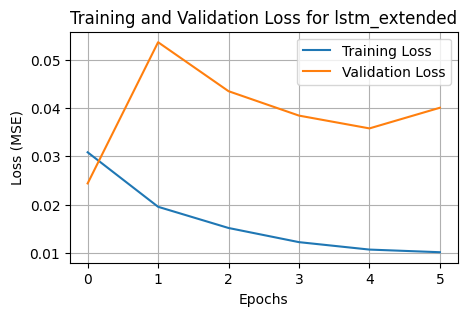

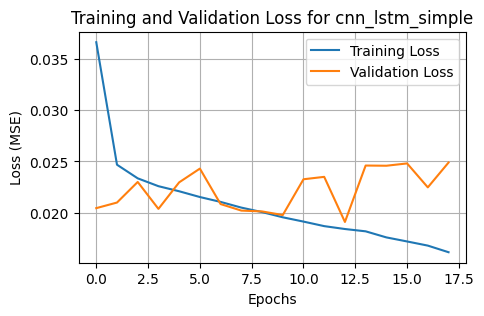

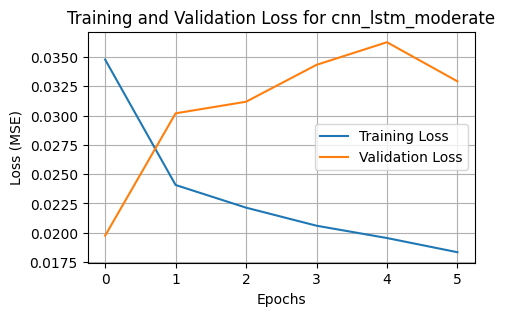

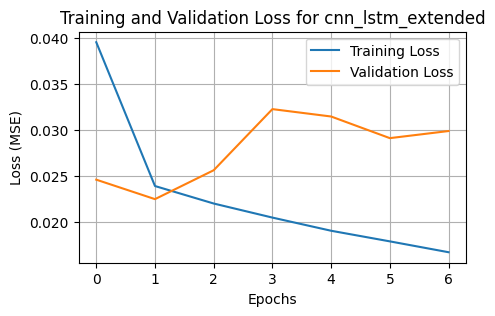

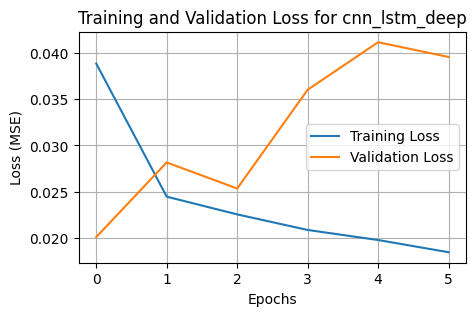

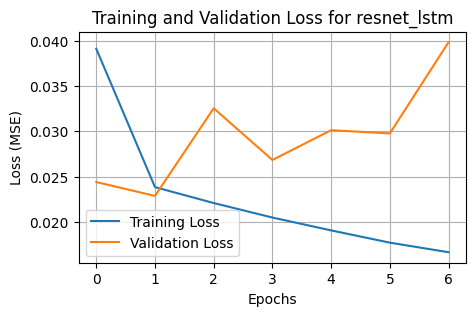

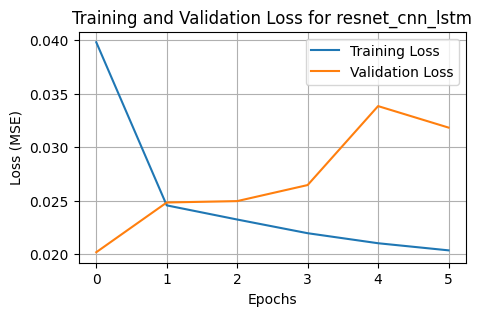

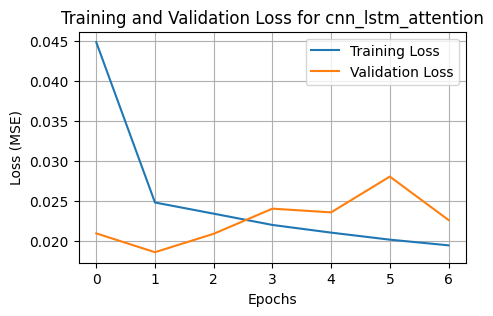

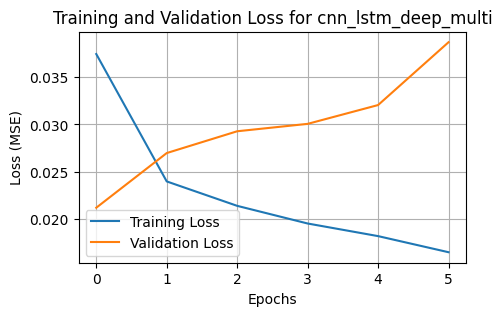

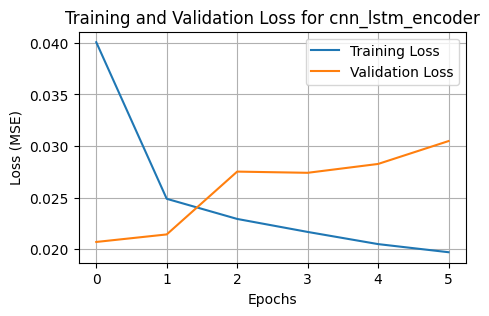

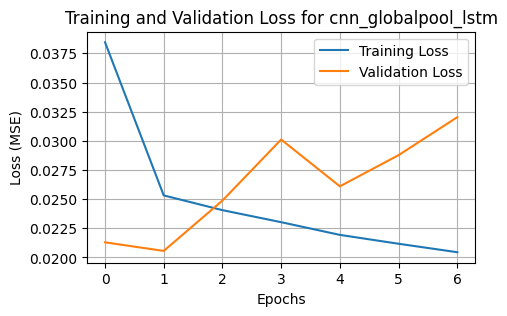

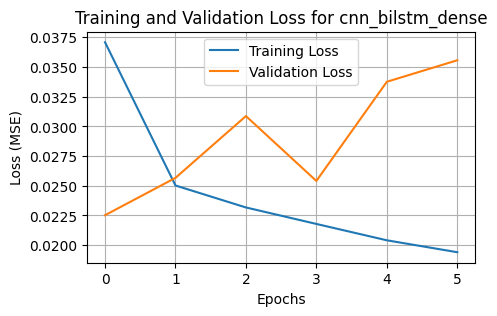

In [38]:
for model_data in model_data_list:

    plot_loss(model_data['history'], title = f'Training and Validation Loss for {model_data['name']}')

#### Залишки

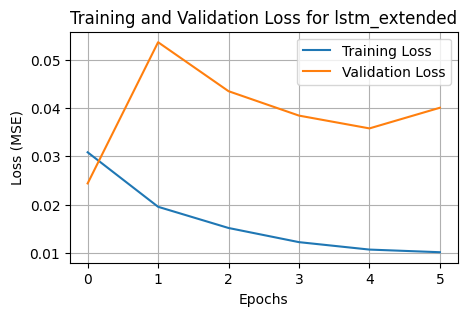

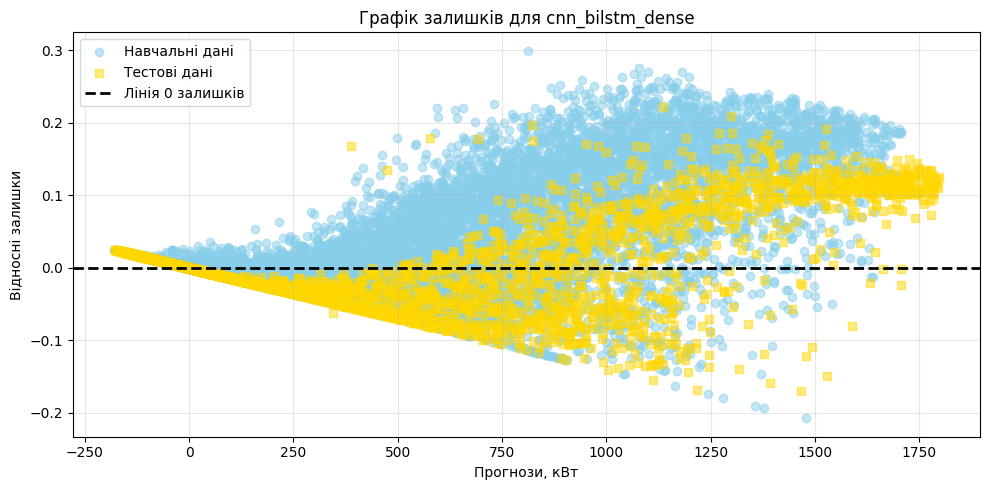

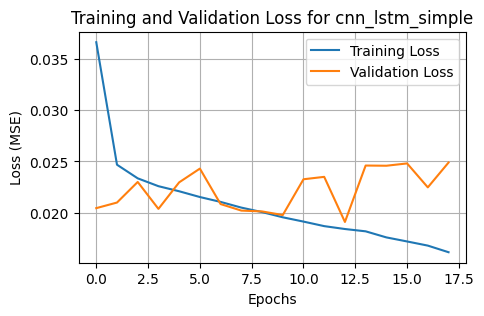

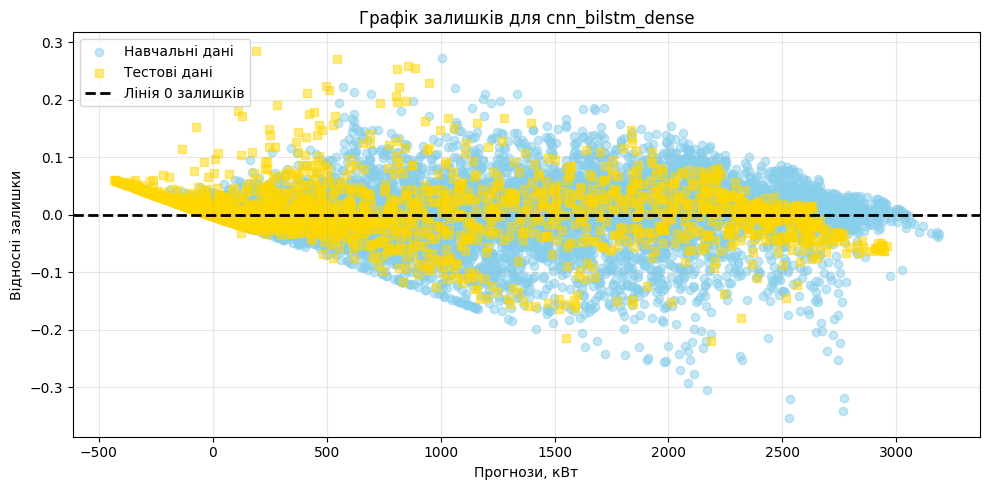

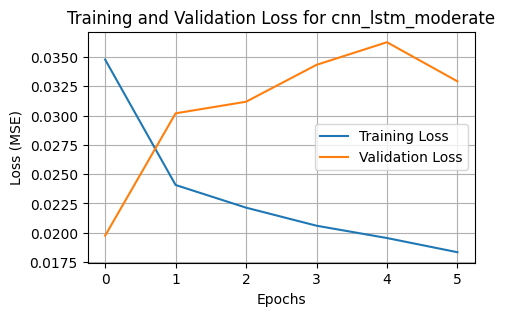

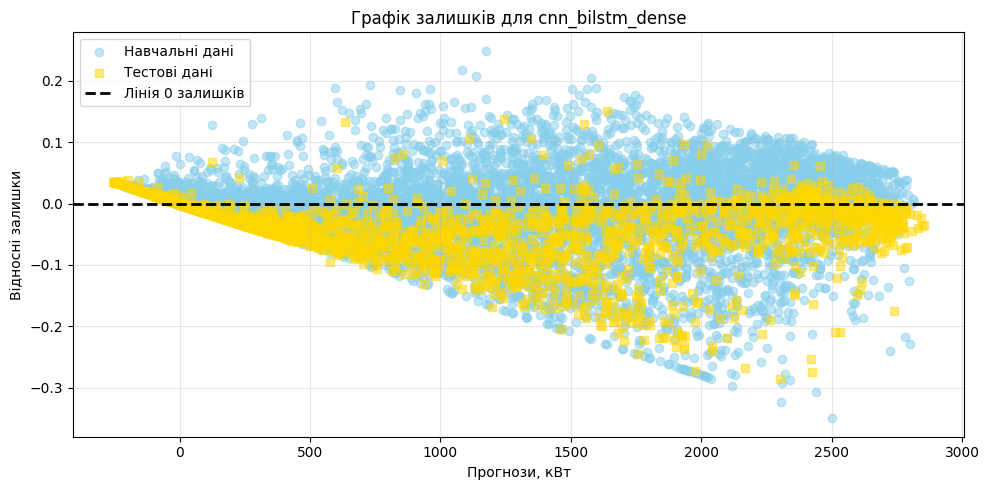

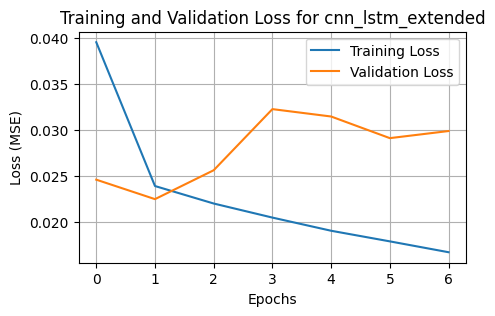

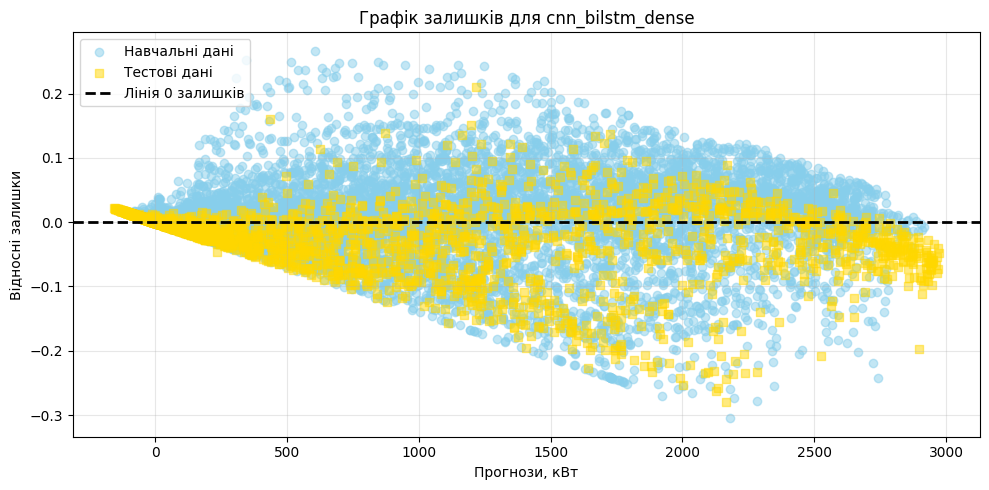

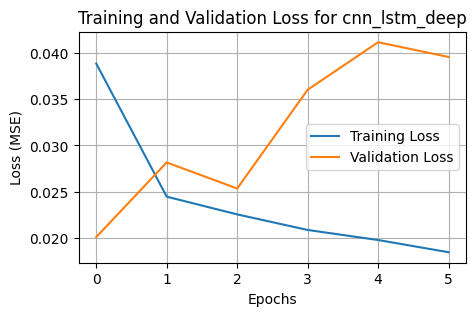

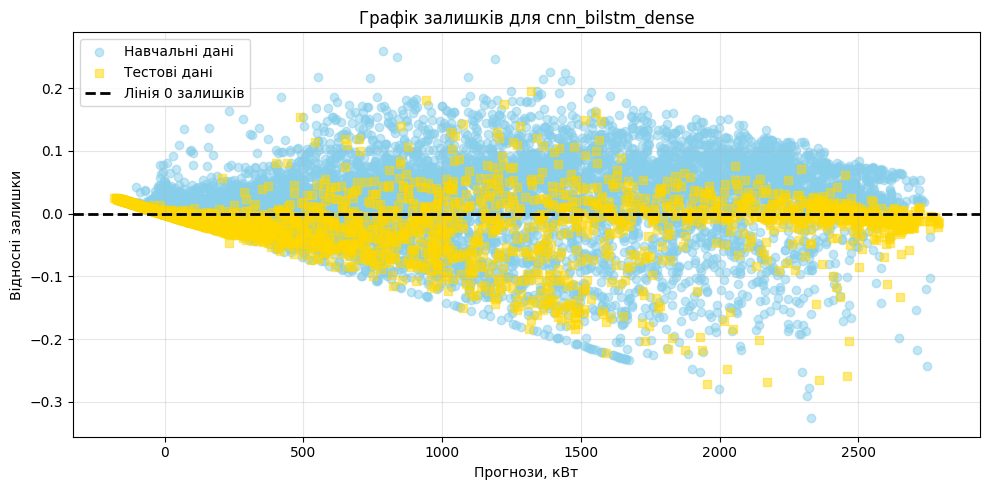

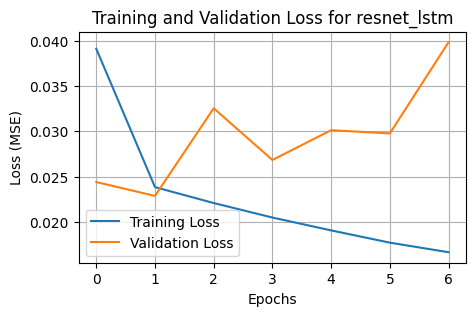

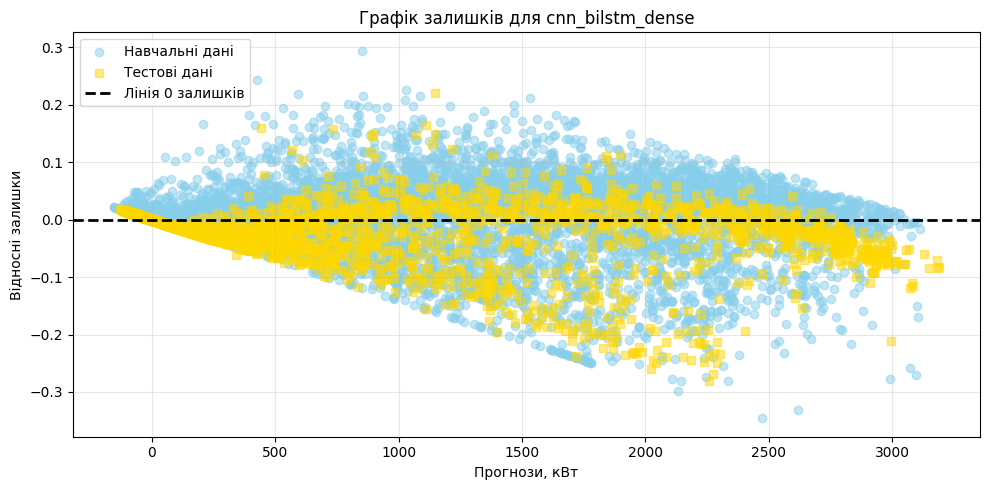

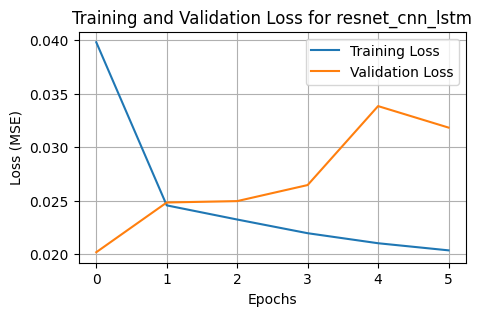

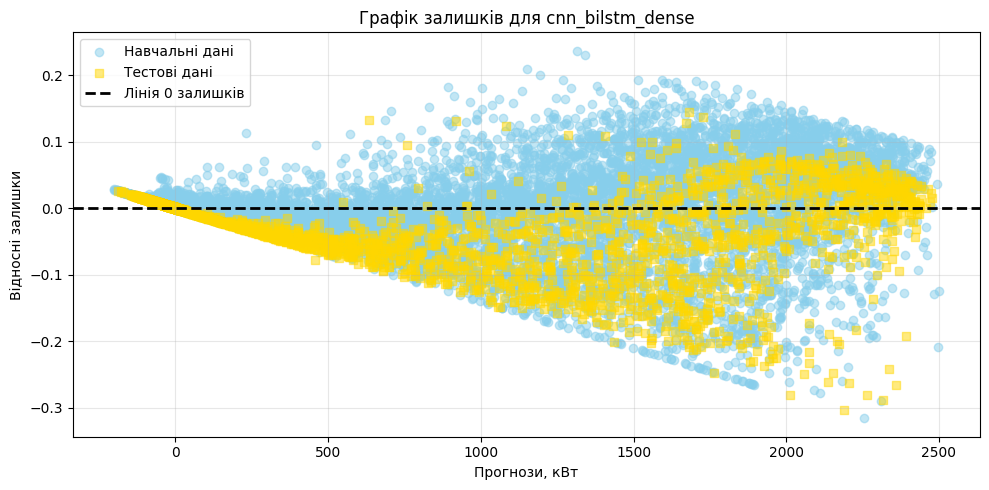

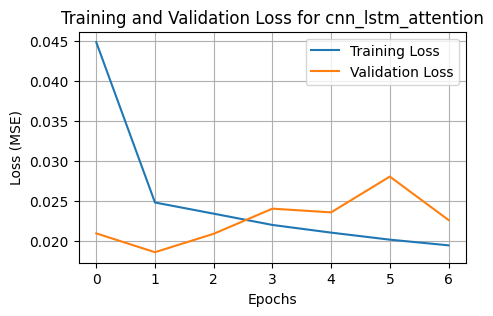

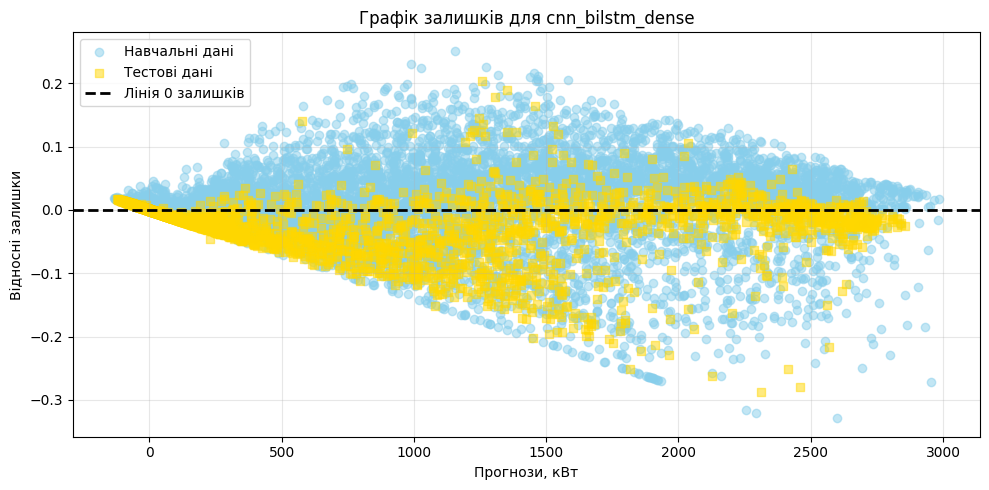

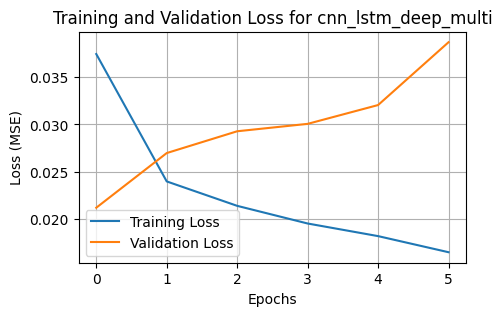

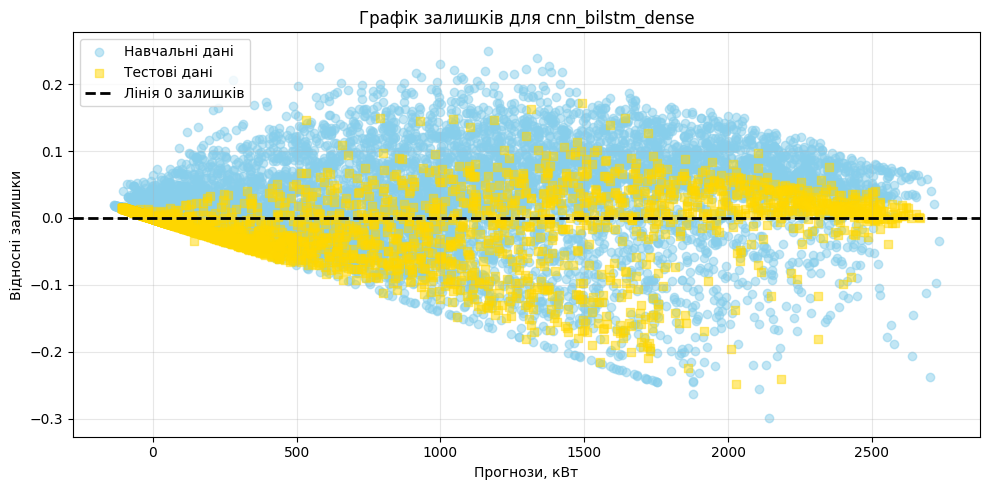

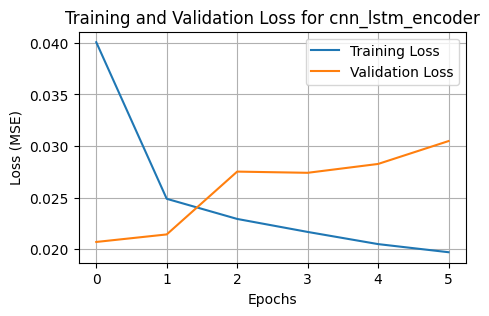

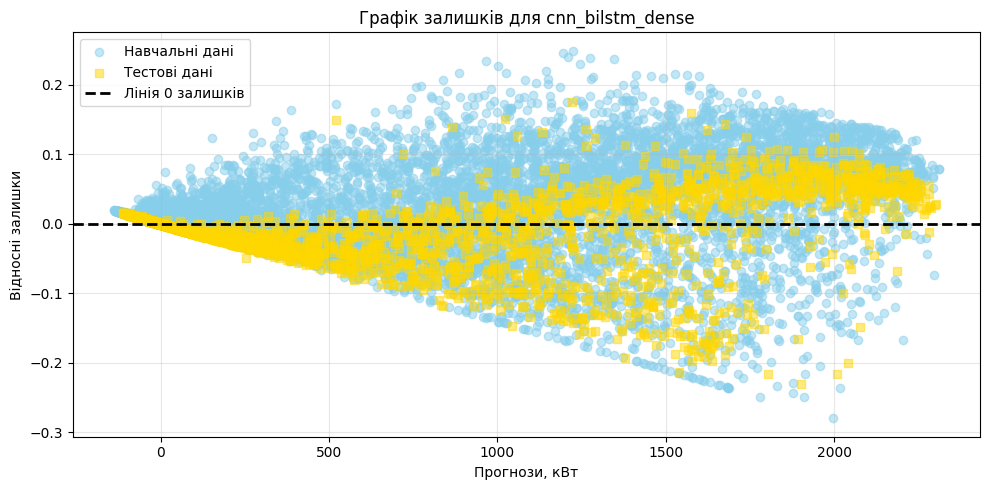

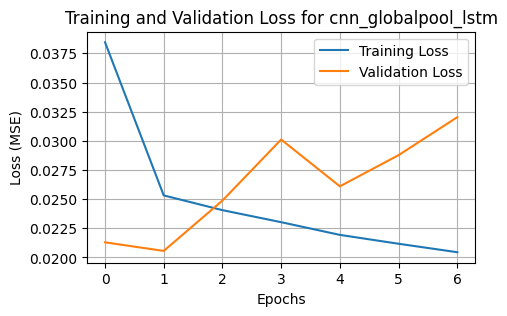

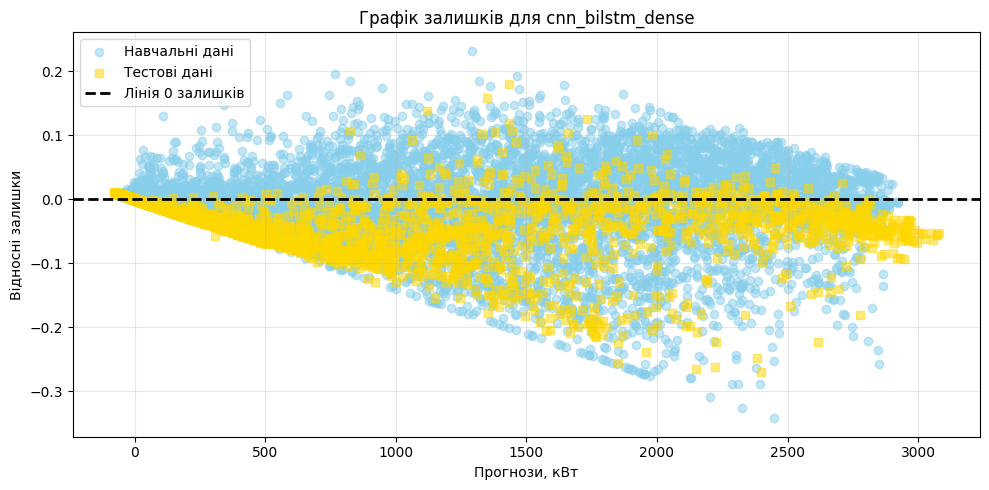

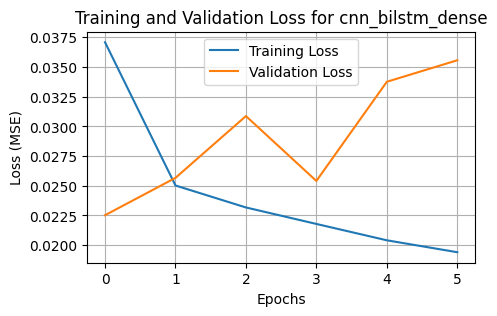

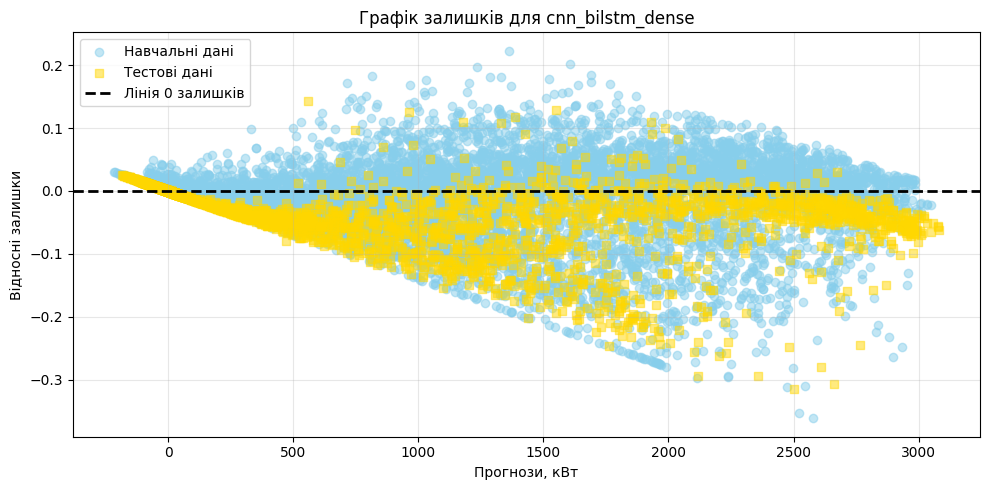

In [39]:
for model_data in model_data_list:

    _data_train = model_data['data_train']
    _data_test = model_data['data']

    plot_loss(model_data['history'], title = f'Training and Validation Loss for {model_data['name']}')
    plot_residuals(
        _y_train_actual=_data_train['power_actual'],
        _y_train_forecast=_data_train['power_predict'],
        _y_test_actual=_data_test['power_actual'],
        _y_test_forecast=_data_test['power_predict'],
        _power_max=power_max,
        _title=f"Графік залишків для {model_name}"
    )

#### Метрики

In [40]:
for model_data in model_data_list:
    model_data['metrics']['Модель'] = model_data.get('name')

# Вибір колонок для виводу
selected_columns = [
    "Модель", "TAE", "MAE", "MAE(max)", "APE", "MAPE", "MAPE(max)",
    "sMAPE", "MSE", "RMSE", "RMSE(max)", "R2", "MSLE", "EV", "PCC", "Bias"
]

positive_metrics = ["R2", "EV", "PCC"]  # "+" чим вище - тим краще
negative_metrics = [
    "TAE", "MAE", "MAE(max)", "APE", "MAPE", "MAPE(max)", "sMAPE",
    "MSE", "RMSE", "RMSE(max)", "MSLE", "Bias"
]  # "-" чим нижче - тим краще

# Формування даних для таблиці
metrics_array = [
    {key: model['metrics'][key] for key in selected_columns if key in model['metrics']}
    for model in model_data_list
]

# Створення таблиці та округлення
metrics_table = pd.DataFrame(metrics_array)
metrics_table = metrics_table.round(2)
metrics_table.set_index('Модель', inplace=True)

# Обчислення і сортування рейтингу
metrics_table['Рейтинг'] = (
    metrics_table[negative_metrics].sum(axis=1) + (1 - metrics_table[positive_metrics]).sum(axis=1)
)
metrics_table = metrics_table.sort_values(by='Рейтинг')

display(metrics_table.sort_values(by='Рейтинг'))


TAE     MAE  MAE(max)    APE   MAPE  MAPE(max)  \
Модель                                                                       
cnn_lstm_deep         568082.78  172.20      2.41  24.43  67.27       2.41   
cnn_lstm_simple       590874.24  179.11      2.50  22.88  95.40       2.50   
cnn_lstm_deep_multi   639947.56  193.98      2.71  27.54  70.16       2.71   
cnn_lstm_attention    666780.98  202.12      2.83  27.07  67.46       2.83   
cnn_lstm_extended     687579.88  208.42      2.91  28.91  70.51       2.91   
resnet_lstm           700325.53  212.28      2.97  26.51  67.31       2.97   
cnn_lstm_encoder      721920.99  218.83      3.06  31.11  69.37       3.06   
cnn_globalpool_lstm   829457.45  251.43      3.51  30.71  76.74       3.51   
cnn_lstm_moderate     825059.80  250.09      3.50  30.48  76.69       3.50   
cnn_bilstm_dense      849297.60  257.44      3.60  31.88  69.75       3.60   
resnet_cnn_lstm       908685.90  275.44      3.85  34.84  71.25       3.85   
lstm_extended        1026384.52  311.12      4.35  48.04  75.15       4.35   

                      sMAPE        MSE    RMSE  RMSE(max)    R2  MSLE    EV  \
Модель                                                                        
cnn_lstm_deep        119.13   87197.78  295.29       4.13  0.88  0.46  0.89   
cnn_lstm_simple      121.33   82556.87  287.33       4.02  0.89  1.00  0.89   
cnn_lstm_deep_multi  122.66   98869.35  314.43       4.40  0.84  0.48  0.85   
cnn_lstm_attention   123.73  108580.94  329.52       4.61  0.85  0.47  0.88   
cnn_lstm_extended    122.22  129726.50  360.18       5.04  0.84  0.39  0.86   
resnet_lstm          122.78  123306.26  351.15       4.91  0.85  0.48  0.87   
cnn_lstm_encoder     123.37  113014.02  336.18       4.70  0.79  0.42  0.79   
cnn_globalpool_lstm  126.50  143125.26  378.32       5.29  0.83  0.54  0.89   
cnn_lstm_moderate    127.52  151183.22  388.82       5.44  0.82  0.98  0.87   
cnn_bilstm_dense     128.42  170042.05  412.36       5.76  0.81  0.64  0.87   
resnet_cnn_lstm      129.88  186489.61  431.84       6.04  0.74  0.62  0.78   
lstm_extended        129.11  181379.15  425.89       5.95  0.42  0.80  0.42   

                      PCC  Bias     Рейтинг  
Модель                                       
cnn_lstm_deep        0.94 -0.95   655967.63  
cnn_lstm_simple      0.95  0.79   674148.24  
cnn_lstm_deep_multi  0.93 -0.85   739555.51  
cnn_lstm_attention   0.94 -2.01   776120.88  
cnn_lstm_extended    0.93 -1.66   818106.58  
resnet_lstm          0.93 -1.80   824421.70  
cnn_lstm_encoder     0.92 -0.64   835724.97  
cnn_globalpool_lstm  0.94 -3.11   973456.49  
cnn_lstm_moderate    0.93 -2.98   977127.44  
cnn_bilstm_dense     0.93 -3.10  1020250.39  
resnet_cnn_lstm      0.89 -2.41  1096131.30  
lstm_extended        0.90  0.35  1208770.04

In [41]:
for model_data in model_data_list:
    model_data['metrics']['Модель'] = model_data.get('name')

# Вибір колонок для виводу
selected_columns = [
    "Модель", "TAE", "MAE", "MAE(max)", "APE", "MAPE", "MAPE(max)",
    "sMAPE", "MSE", "RMSE", "RMSE(max)", "R2", "MSLE", "EV", "PCC", "Bias"
]

# Позначки для підрахунку рейтингу
positive_metrics = ["R2", "EV", "PCC"]  # "+" чим вище - тим краще
negative_metrics = [
    "TAE", "MAE", "MAE(max)", "APE", "MAPE", "MAPE(max)", "sMAPE",
    "MSE", "RMSE", "RMSE(max)", "MSLE", "Bias"
]  # "-" чим нижче - тим краще

# Формування даних для таблиці
metrics_array = [
    {key: model['metrics'][key] for key in selected_columns if key in model['metrics']}
    for model in model_data_list
]

# Створення таблиці та округлення
metrics_table = pd.DataFrame(metrics_array)
metrics_table = metrics_table.round(2)
metrics_table.set_index('Модель', inplace=True)

# Нормалізація метрик
for column in positive_metrics:
    if column in metrics_table:
        metrics_table[column] = metrics_table[column] / metrics_table[column].max()

for column in negative_metrics:
    if column in metrics_table:
        metrics_table[column] = 1 - (metrics_table[column] / metrics_table[column].max())

# Розрахунок рейтингу
metrics_table['Рейтиг'] = metrics_table[positive_metrics + negative_metrics].mean(axis=1).rank(ascending=False)

# Вивід таблиці
display(metrics_table.sort_values(by='Рейтиг'))


TAE       MAE  MAE(max)       APE      MAPE  \
Модель                                                                  
cnn_globalpool_lstm  0.191865  0.191855  0.193103  0.360741  0.195597   
cnn_lstm_attention   0.350359  0.350347  0.349425  0.436511  0.292872   
cnn_bilstm_dense     0.172535  0.172538  0.172414  0.336386  0.268868   
cnn_lstm_deep        0.446521  0.446516  0.445977  0.491465  0.294864   
resnet_lstm          0.317677  0.317691  0.317241  0.448168  0.294444   
cnn_lstm_moderate    0.196149  0.196162  0.195402  0.365529  0.196122   
cnn_lstm_extended    0.330095  0.330098  0.331034  0.398210  0.260901   
cnn_lstm_deep_multi  0.376503  0.376511  0.377011  0.426728  0.264570   
resnet_cnn_lstm      0.114673  0.114682  0.114943  0.274771  0.253145   
cnn_lstm_encoder     0.296637  0.296638  0.296552  0.352415  0.272851   
cnn_lstm_simple      0.424315  0.424306  0.425287  0.523730  0.000000   
lstm_extended        0.000000  0.000000  0.000000  0.000000  0.212264   

                     MAPE(max)     sMAPE       MSE      RMSE  RMSE(max)  \
Модель                                                                    
cnn_globalpool_lstm   0.193103  0.026024  0.232530  0.123935   0.124172   
cnn_lstm_attention    0.349425  0.047351  0.417764  0.236940   0.236755   
cnn_bilstm_dense      0.172414  0.011241  0.088196  0.045109   0.046358   
cnn_lstm_deep         0.445977  0.082769  0.532426  0.316205   0.316225   
resnet_lstm           0.317241  0.054666  0.338804  0.186852   0.187086   
cnn_lstm_moderate     0.195402  0.018171  0.189321  0.099620   0.099338   
cnn_lstm_extended     0.331034  0.058978  0.304377  0.165941   0.165563   
cnn_lstm_deep_multi   0.377011  0.055590  0.469840  0.271883   0.271523   
resnet_cnn_lstm       0.114943  0.000000  0.000000  0.000000   0.000000   
cnn_lstm_encoder      0.296552  0.050123  0.393993  0.221517   0.221854   
cnn_lstm_simple       0.425287  0.065830  0.557311  0.334638   0.334437   
lstm_extended         0.000000  0.005929  0.027403  0.013778   0.014901   

                           R2  MSLE        EV       PCC      Bias  Рейтиг  
Модель                                                                     
cnn_globalpool_lstm  0.932584  0.46  1.000000  0.989474  4.936709     1.0  
cnn_lstm_attention   0.955056  0.53  0.988764  0.989474  3.544304     2.0  
cnn_bilstm_dense     0.910112  0.36  0.977528  0.978947  4.924051     3.0  
cnn_lstm_deep        0.988764  0.54  1.000000  0.989474  2.202532     4.0  
resnet_lstm          0.955056  0.52  0.977528  0.978947  3.278481     5.0  
cnn_lstm_moderate    0.921348  0.02  0.977528  0.978947  4.772152     6.0  
cnn_lstm_extended    0.943820  0.61  0.966292  0.978947  3.101266     7.0  
cnn_lstm_deep_multi  0.943820  0.52  0.955056  0.978947  2.075949     8.0  
resnet_cnn_lstm      0.831461  0.38  0.876404  0.936842  4.050633     9.0  
cnn_lstm_encoder     0.887640  0.58  0.887640  0.968421  1.810127    10.0  
cnn_lstm_simple      1.000000  0.00  1.000000  1.000000  0.000000    11.0  
lstm_extended        0.471910  0.20  0.471910  0.947368  0.556962    12.0

In [51]:
for model_data in model_data_list:
    
    model_data['metrics']['Модель'] = model_data.get('name')

    positive_metrics = ["APE", "MAE(max)", "MAPE(max)", "RMSE", "RMSE(max)", "MSLE", "Bias"],
    negative_metrics = ["R2", "EV", "PCC"]
    
    # Визначення ваг для метрик
    weights = {
        "TAE": 10,
        "MAE": 1,
        "MAE(max)": 1,
        "APE": 10,
        "MAPE(max)": 1,
        "sMAPE": 1,
        "RMSE": 1,
        "RMSE(max)": 1,
        "MSLE": 10,
        "Bias": 1,
        "R2": 10,
        "EV": 1,
        "PCC": 1
    }

    rate_column = 'rate'
    model_column = 'model'

    metrics_df = pd.DataFrame([model_data['metrics']])
    # Фільтрація числових колонок для розрахунків рейтингу
    numeric_columns = metrics_df.select_dtypes(include=["number"]).columns.tolist()

    positive_metrics_numeric = [col for col in positive_metrics if col in numeric_columns]
    negative_metrics_numeric = [col for col in negative_metrics if col in numeric_columns]

    # Копія метрик для обчислення рейтингу
    metrics_for_ranking = metrics_df.copy()

    # Нормалізація для рейтингу
    for col in positive_metrics_numeric:
        metrics_for_ranking[col] = metrics_for_ranking[col] / metrics_for_ranking[col].max()

    for col in negative_metrics_numeric:
        metrics_for_ranking[col] = 1 - (metrics_for_ranking[col] / metrics_for_ranking[col].max())

    # Застосування ваг
    weighted_metrics = metrics_for_ranking[positive_metrics_numeric + negative_metrics_numeric].mul(
        [weights.get(col, 1) for col in positive_metrics_numeric + negative_metrics_numeric], axis=1
    )

    # Розрахунок рейтингу
    metrics_df = metrics_df.copy()  # Уникаємо модифікації вихідного DataFrame
    metrics_df.loc[:, rate_column] = weighted_metrics.sum(axis=1)

    # Нормалізація рейтингу до [0, 100]
    metrics_df.loc[:, rate_column] = (metrics_df[rate_column] - metrics_df[rate_column].min()) / (metrics_df[rate_column].max() - metrics_df[rate_column].min()) * 100

    # Сортування за рейтингом
    metrics_rated_df = metrics_df.sort_values(by=rate_column, ascending=False)

    # Підготовка колонок
    preferred_columns = [model_column, rate_column]
    all_columns = metrics_rated_df.columns.tolist()
    reordered_columns = [col for col in preferred_columns if col in all_columns] + [col for col in all_columns if col not in preferred_columns]

    # Перестановка колонок
    metrics_rated_df = metrics_rated_df[reordered_columns]

    display(metrics_rated_df)

rate           TAE         MAE  MAE(max)        APE       MAPE  MAPE(max)  \
0   NaN  1.026385e+06  311.119892  4.349502  48.042113  75.147181   4.349502   

        sMAPE            MSE        RMSE  RMSE(max)        R2      MSLE  \
0  129.114672  181379.151127  425.886312   5.953954  0.419583  0.801691   

         EV       PCC      Bias         Модель  
0  0.421572  0.896638  0.348545  lstm_extended

rate            TAE         MAE  MAE(max)        APE       MAPE  MAPE(max)  \
0   NaN  590874.237051  179.107074  2.503943  22.877629  95.398999   2.503943   

        sMAPE           MSE        RMSE  RMSE(max)        R2      MSLE  \
0  121.327831  82556.869728  287.327113   4.016876  0.887429  1.001296   

         EV       PCC      Bias           Модель  
0  0.891837  0.945376  0.794803  cnn_lstm_simple

rate            TAE         MAE  MAE(max)        APE       MAPE  MAPE(max)  \
0   NaN  825059.796237  250.093906   3.49635  30.482028  76.692679    3.49635   

        sMAPE           MSE       RMSE  RMSE(max)        R2      MSLE  \
0  127.523533  151183.21678  388.82286   5.435801  0.817732  0.976215   

        EV       PCC      Bias             Модель  
0  0.87263  0.934156 -2.983218  cnn_lstm_moderate

rate            TAE         MAE  MAE(max)        APE       MAPE  MAPE(max)  \
0   NaN  687579.876017  208.420696  2.913752  28.906409  70.513097   2.913752   

        sMAPE            MSE        RMSE  RMSE(max)        R2      MSLE  \
0  122.217969  129726.499226  360.175651   5.035309  0.843701  0.389541   

         EV       PCC      Bias             Модель  
0  0.860632  0.927705 -1.657257  cnn_lstm_extended

rate            TAE         MAE  MAE(max)        APE       MAPE  MAPE(max)  \
0   NaN  568082.776091  172.198477   2.40736  24.426029  67.272392    2.40736   

       sMAPE           MSE        RMSE  RMSE(max)        R2      MSLE  \
0  119.12653  87197.775376  295.292694   4.128236  0.881464  0.459162   

         EV       PCC      Bias         Модель  
0  0.887693  0.943212 -0.946299  cnn_lstm_deep

rate            TAE         MAE  MAE(max)        APE       MAPE  MAPE(max)  \
0   NaN  700325.525939  212.284185  2.967764  26.508761  67.310712   2.967764   

        sMAPE            MSE       RMSE  RMSE(max)        R2      MSLE  \
0  122.782075  123306.259504  351.14991   4.909128  0.846683  0.482532   

         EV       PCC      Bias       Модель  
0  0.867314  0.931387 -1.800801  resnet_lstm

rate            TAE         MAE  MAE(max)        APE       MAPE  MAPE(max)  \
0   NaN  908685.903367  275.442832  3.850732  34.842979  71.254382   3.850732   

        sMAPE            MSE        RMSE  RMSE(max)        R2      MSLE  \
0  129.882991  186489.610957  431.844429   6.037249  0.743829  0.622036   

        EV      PCC      Bias           Модель  
0  0.78461  0.89153 -2.408795  resnet_cnn_lstm

rate            TAE         MAE  MAE(max)        APE       MAPE  MAPE(max)  \
0   NaN  666780.978844  202.116089  2.825613  27.067979  67.458185   2.825613   

        sMAPE            MSE        RMSE  RMSE(max)        R2      MSLE  \
0  123.731575  108580.938422  329.516219   4.606686  0.852041  0.470738   

         EV       PCC      Bias              Модель  
0  0.880141  0.939447 -2.007584  cnn_lstm_attention

rate            TAE         MAE  MAE(max)       APE       MAPE  MAPE(max)  \
0   NaN  639947.557327  193.982285  2.711901  27.53523  70.160171   2.711901   

        sMAPE           MSE        RMSE  RMSE(max)        R2      MSLE  \
0  122.659044  98869.347251  314.434965   4.395847  0.843822  0.479712   

         EV       PCC      Bias               Модель  
0  0.849694  0.931347 -0.852364  cnn_lstm_deep_multi

rate            TAE         MAE  MAE(max)        APE       MAPE  MAPE(max)  \
0   NaN  721920.985534  218.830247  3.059279  31.108324  69.373653   3.059279   

        sMAPE            MSE        RMSE  RMSE(max)        R2     MSLE  \
0  123.372653  113014.021278  336.175581   4.699784  0.789926  0.42236   

         EV       PCC     Bias            Модель  
0  0.793818  0.921078 -0.63963  cnn_lstm_encoder

rate            TAE         MAE  MAE(max)        APE       MAPE  MAPE(max)  \
0   NaN  829457.447389  251.426932  3.514986  30.709806  76.736345   3.514986   

        sMAPE            MSE        RMSE  RMSE(max)        R2      MSLE  \
0  126.495855  143125.263924  378.318998   5.288956  0.825921  0.536507   

         EV       PCC      Bias               Модель  
0  0.886005  0.941307 -3.107255  cnn_globalpool_lstm

rate            TAE        MAE  MAE(max)        APE       MAPE  MAPE(max)  \
0   NaN  849297.596482  257.44092  3.599062  31.879453  69.745416   3.599062   

        sMAPE            MSE       RMSE  RMSE(max)        R2      MSLE  \
0  128.424251  170042.047779  412.36155   5.764876  0.810854  0.641836   

         EV       PCC      Bias            Модель  
0  0.865506  0.931096 -3.098798  cnn_bilstm_dense

#### Часові ряди



==> lstm_extended



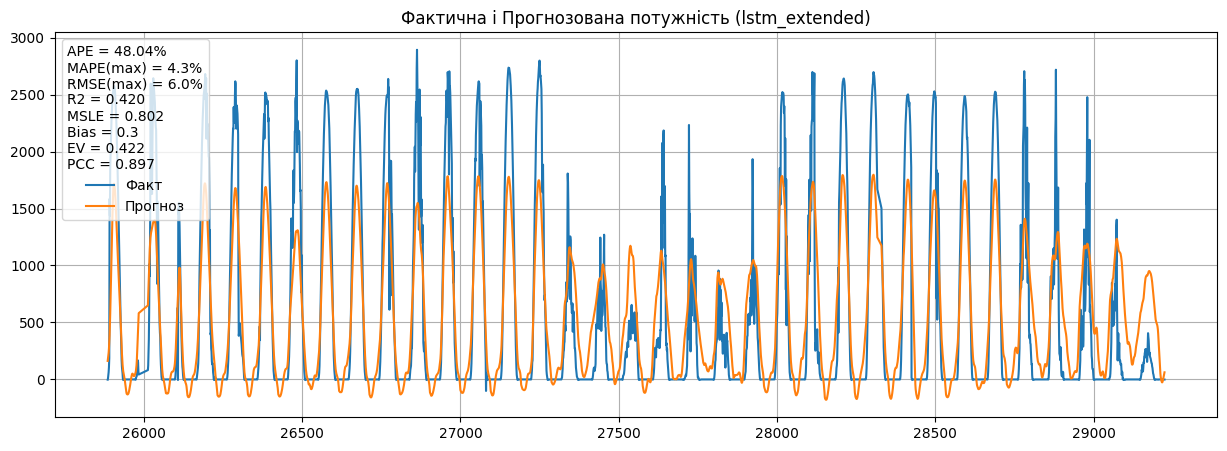



==> cnn_lstm_simple



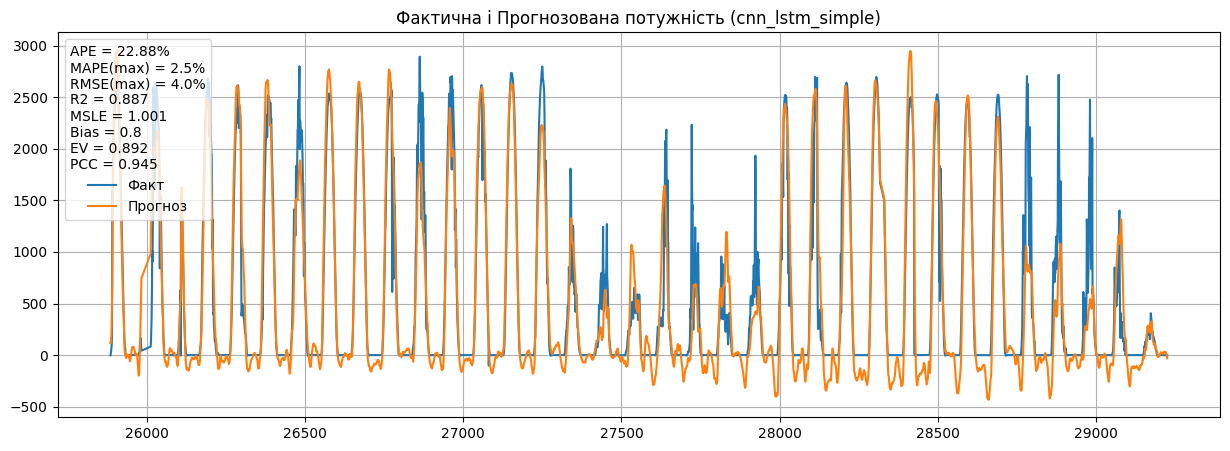



==> cnn_lstm_moderate



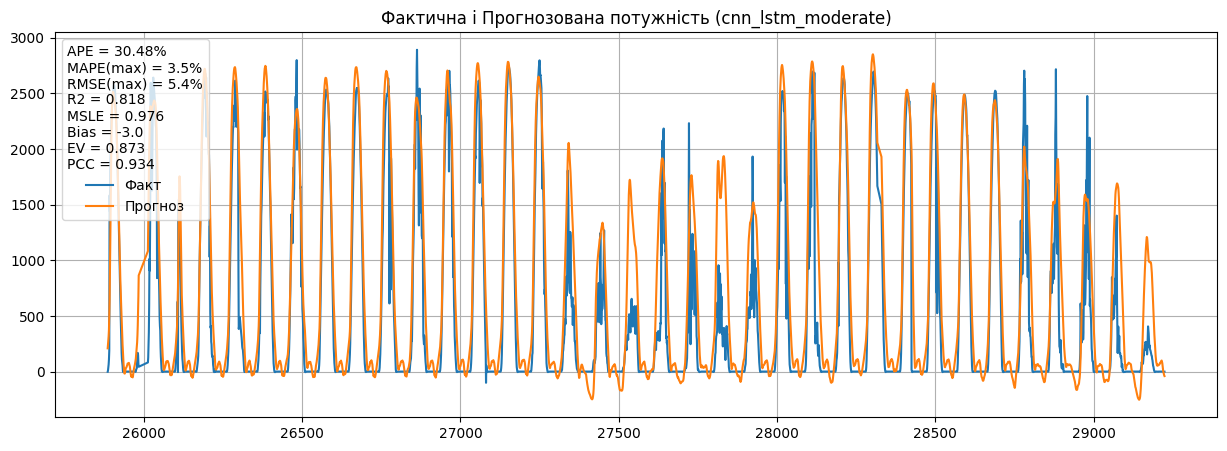



==> cnn_lstm_extended



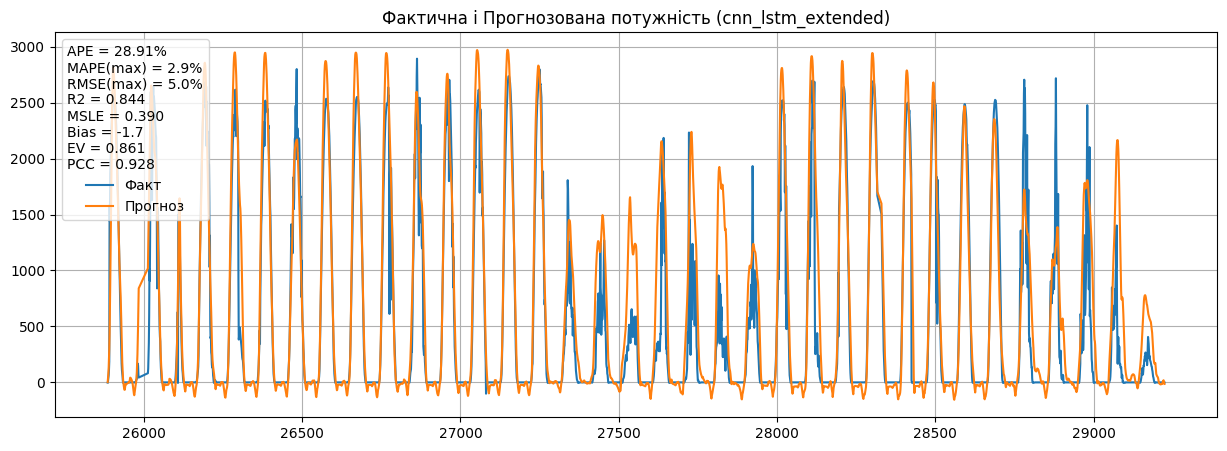



==> cnn_lstm_deep



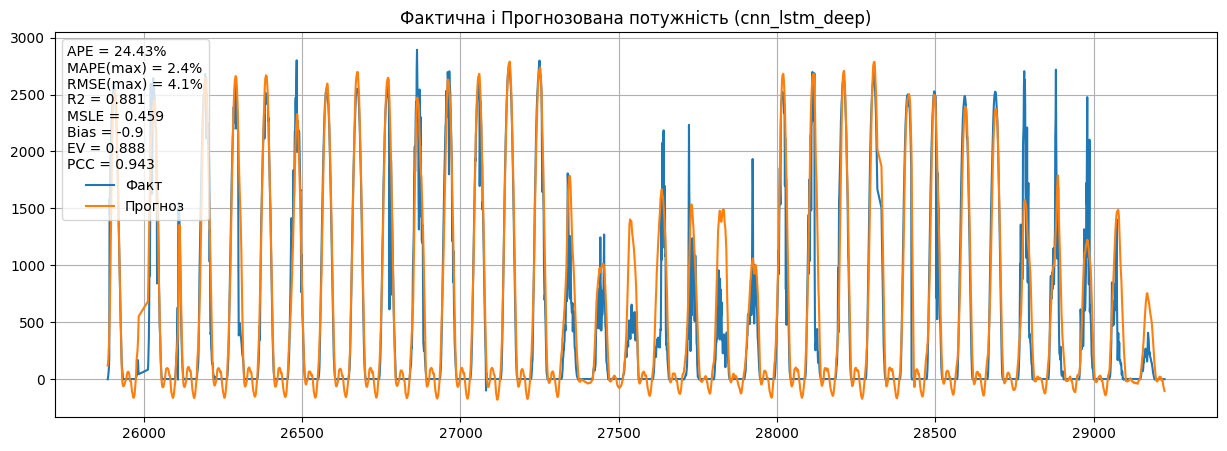



==> resnet_lstm



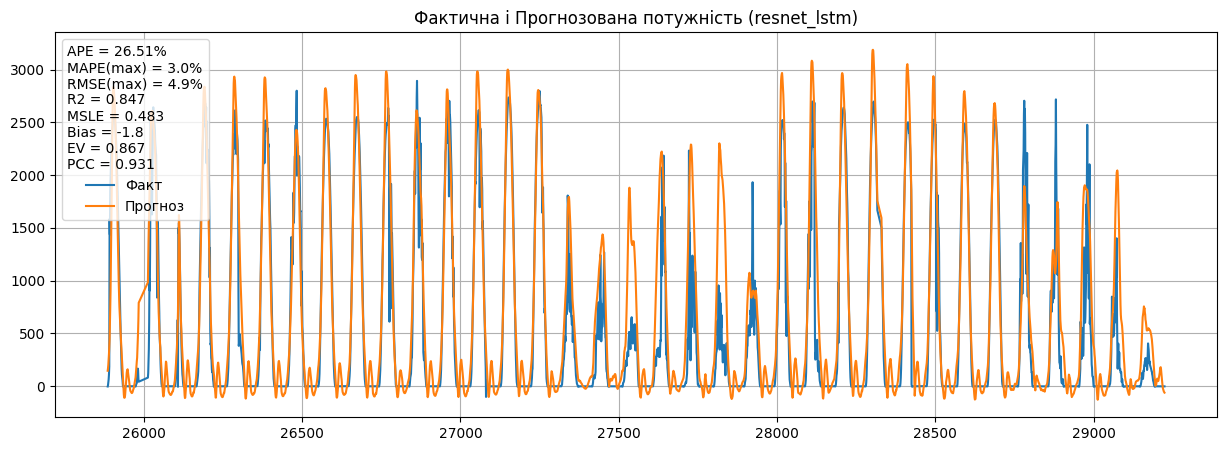



==> resnet_cnn_lstm



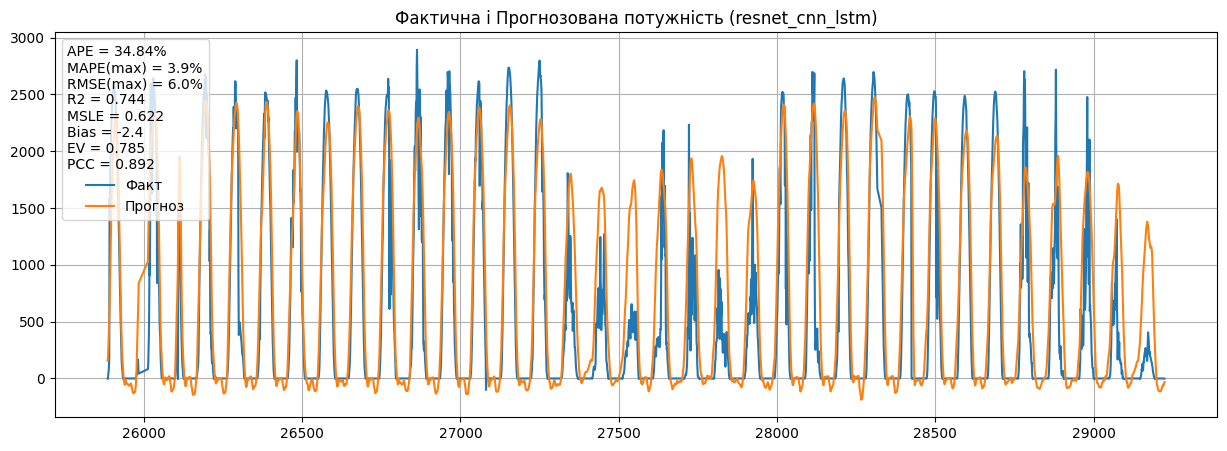



==> cnn_lstm_attention



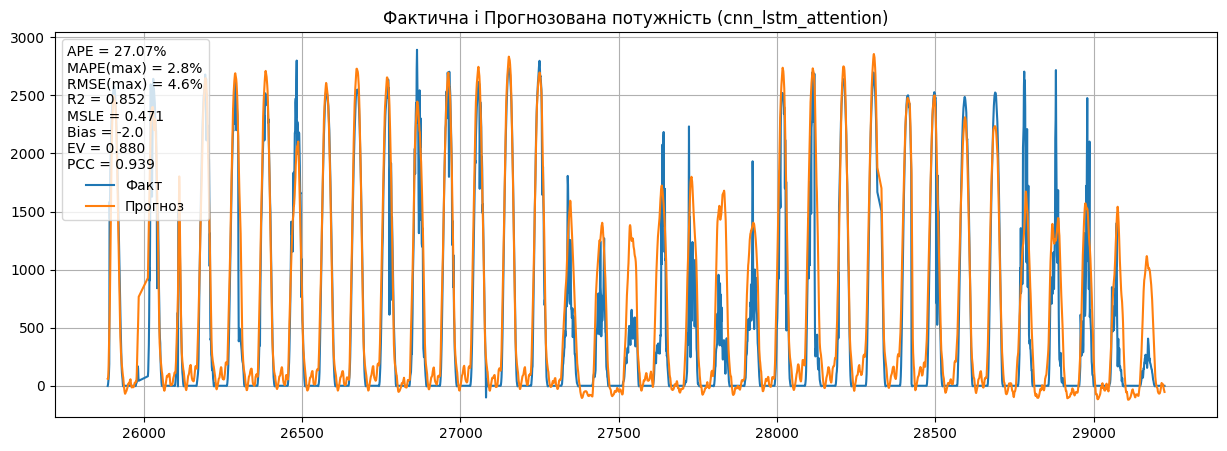



==> cnn_lstm_deep_multi



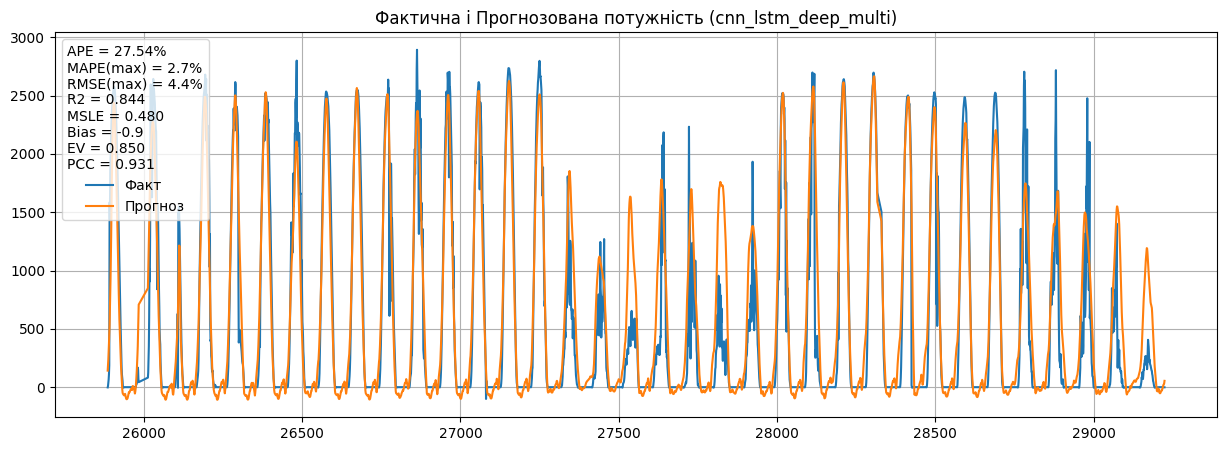



==> cnn_lstm_encoder



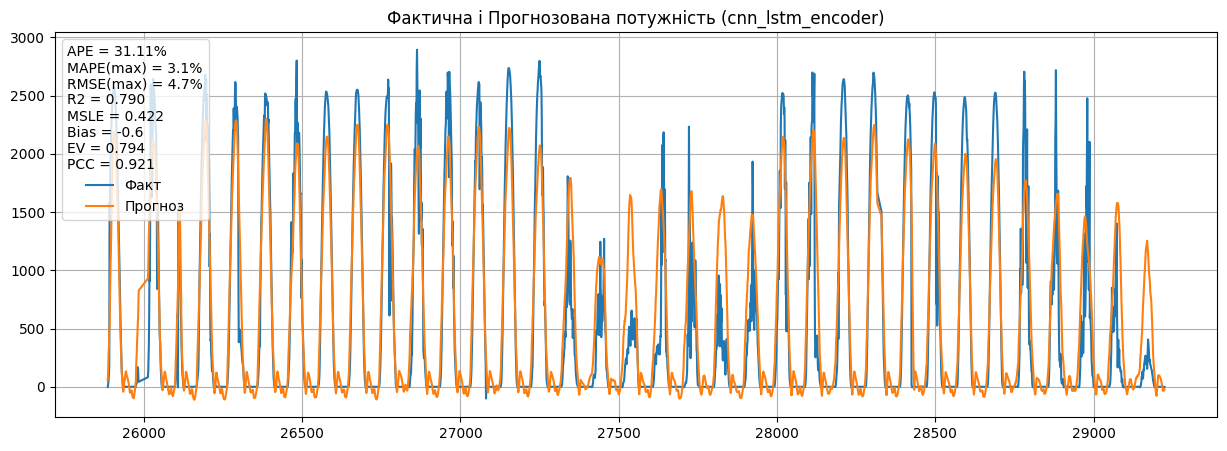



==> cnn_globalpool_lstm



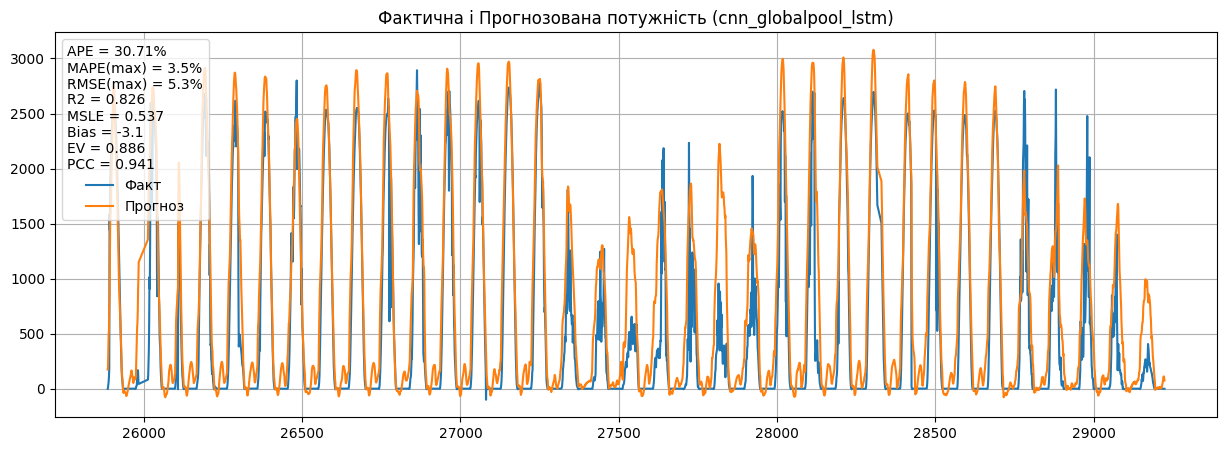



==> cnn_bilstm_dense



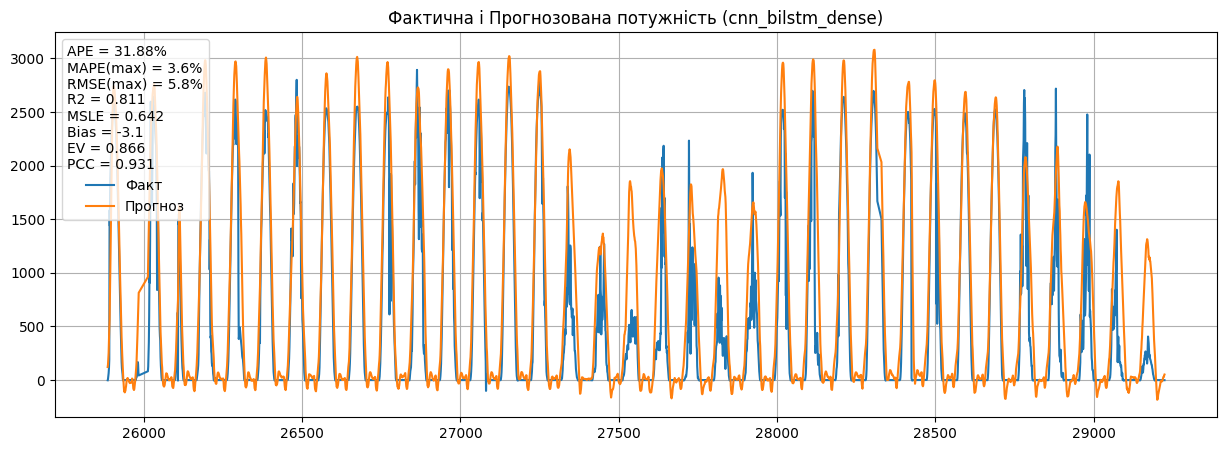

In [42]:
for model_data in model_data_list:
  
    # Оцінка прогнозу і візуалізація часовових рядів потужності
    print(f"\n\n==> {model_data['name']}\n")
    plot_series(_data=model_data['data'],
                _columns=  [{"column": "power_actual", "label": "Факт", "power_max": 0},
                            {"column": "power_predict", "label": "Прогноз", "power_max": 0}],
                _title=f"Фактична і Прогнозована потужність ({model_data['name']})",
                _metrics=model_data['metrics'],
                _split_days=0
                )
